In [22]:
import os
import sys

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import seaborn_image as isns

import keras
from keras.layers import *
from keras.models import Model
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping,ModelCheckpoint

import tensorflow as tf

In [23]:
tf.version.VERSION

'2.8.4'

In [24]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Data Preparation

In [25]:
train_data_csv = pd.read_csv('data/train.csv')

In [26]:
train_featrues, train_targets = (train_data_csv.drop(['label'], axis=1), train_data_csv.label)

In [27]:
train_images = train_featrues.values.astype('float32').reshape(-1, 28, 28, 1)

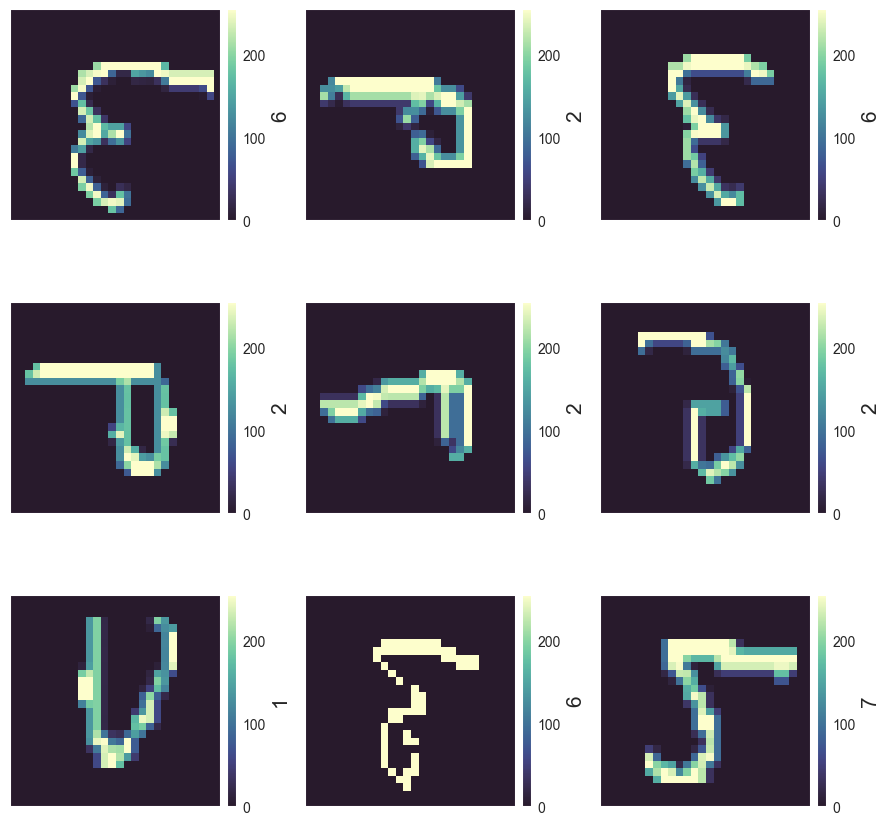

In [28]:
ints = np.random.randint(0, train_images.shape[0], 9)
_ = isns.ImageGrid([train_images[i, :, :, :].reshape(28, 28) for i in ints],
                   cbar_label=[f'{train_targets[i]}' for i in ints],
                   col_wrap=3)

In [29]:
train_targets = tf.keras.utils.to_categorical(train_targets, num_classes=10, dtype='float32')

In [30]:
train_targets.shape

(60000, 10)

## 2. Experiments

In [43]:
def scale_and_augment(input):
    x = Rescaling(1./255)(input)
    x = RandomRotation(.042, fill_mode='constant')(x)
    x = RandomTranslation(.25, .25, fill_mode='constant')(x)
    x = RandomZoom((-.2, .3), fill_mode='constant')(x)

    return x



def conv_block(input, depth, kernel_size, num_kernels, activation, batchnorm):
    for _ in range(depth):
        x = Conv2D(filters=num_kernels,
                   kernel_size=kernel_size,
                   padding='same',
                   )(input)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)

    return x


In [32]:
def build_cnn_1(weights=None):
    name = 'cnn_1'
    inputs = Input(shape=train_images.shape[1:])

    x = scale_and_augment(inputs)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=64,
                   activation='relu',
                   batchnorm=True)


    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=128,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=256,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(loss=CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

    if weights is not None:
        model.load_weights(weights)

    return model

In [33]:
def build_cnn_2(weights=None):
    name = 'cnn_2'
    inputs = Input(shape=train_images.shape[1:])

    x = scale_and_augment(inputs)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=16,
                   activation='relu',
                   batchnorm=True)


    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=32,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=64,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=128,
                   activation='relu',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(loss=CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

    if weights is not None:
        model.load_weights(weights)

    return model

In [34]:
def build_cnn_3(weights=None):
    name = 'cnn_3'
    inputs = Input(shape=train_images.shape[1:])

    x = scale_and_augment(inputs)

    x1 = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=32,
                   activation='swish',
                   batchnorm=True)

    x2 = conv_block(input=x,
               depth=2,
               kernel_size=5,
               num_kernels=32,
               activation='swish',
               batchnorm=True)

    x2 = conv_block(input=x2,
               depth=2,
               kernel_size=3,
               num_kernels=32,
               activation='swish',
               batchnorm=True)

    x3 = conv_block(input=x,
               depth=1,
               kernel_size=7,
               num_kernels=32,
               activation='swish',
               batchnorm=True)


    x = Concatenate()([x1, x2, x3])

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.2)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=128,
                   activation='swish',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.2)(x)

    x = conv_block(input=x,
                   depth=3,
                   kernel_size=3,
                   num_kernels=256,
                   activation='swish',
                   batchnorm=True)

    x = MaxPool2D(2, 2)(x)
    x = Dropout(.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='swish')(x)
    x = BatchNormalization()(x)

    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(loss=CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

    if weights is not None:
        model.load_weights(weights)

    return model, name

In [35]:
model, name = build_cnn_3()

In [36]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 28, 28, 1)    0           ['input_2[0][0]']                
                                                                                                  
 random_rotation_1 (RandomRotat  (None, 28, 28, 1)   0           ['rescaling_1[0][0]']            
 ion)                                                                                             
                                                                                                  
 random_translation_1 (RandomTr  (None, 28, 28, 1)   0           ['random_rotation_1[0][0]']

In [37]:
ds = tf.data.Dataset.from_tensor_slices((train_images, train_targets))

In [38]:
def brightness_augment(image, target):
    image = tf.math.multiply(image, tf.random.uniform(shape=[], minval=.9, maxval=1))

    return image, target

In [39]:
SPLIT = .15
BATCH_SIZE = 2048

ds_eval = ds.take(round(train_targets.shape[0]*SPLIT))
ds_train = ds.skip(round(train_targets.shape[0]*SPLIT))

# ds_train = ds_train.map(brightness_augment)

ds_train = ds_train.batch(BATCH_SIZE)
ds_eval = ds_eval.batch(BATCH_SIZE)

In [40]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)

In [41]:
history = model.fit(
                    ds_train,
                    validation_data=ds_eval,
                    epochs=150,
                    callbacks=[ModelCheckpoint(f'./models/{name}/weights_best.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)]
                    )

Epoch 1/500
25/25 [==============================] - ETA: 0s - loss: 1.0242 - accuracy: 0.6696
Epoch 1: val_accuracy improved from -inf to 0.17978, saving model to ./models/cnn_3\weights_best.h5
25/25 [==============================] - 9s 151ms/step - loss: 1.0242 - accuracy: 0.6696 - val_loss: 2.3891 - val_accuracy: 0.1798
Epoch 2/500
25/25 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.9035
Epoch 2: val_accuracy did not improve from 0.17978
25/25 [==============================] - 3s 131ms/step - loss: 0.2993 - accuracy: 0.9035 - val_loss: 2.7483 - val_accuracy: 0.1000
Epoch 3/500
25/25 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.9402
Epoch 3: val_accuracy did not improve from 0.17978
25/25 [==============================] - 3s 126ms/step - loss: 0.1851 - accuracy: 0.9402 - val_loss: 3.0071 - val_accuracy: 0.1093
Epoch 4/500
25/25 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.9513
Epoch 4: val_accuracy did

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'], 'g')
plt.plot(history.history['val_loss'], 'r')
plt.title(f'{name} Loss across epochs\n')
plt.ylabel('Loss')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')

In [ ]:
model.load_weights(f'./models/{name}/weights_best.h5')

scores = model.evaluate(ds_eval)

os.makedirs(f'./models/{name}/model', exist_ok=True)
model.save(filepath=f'./models/{name}/model', save_format='tf')

print("done training!")

original_stdout = sys.stdout
with open(f'./models/{name}/training.info', 'w') as f:
    sys.stdout = f

    print(f'\n\n***MODEL SUMMARY***\nacc: {scores[2]}')
    print(model.summary())
    print('\n\n****FLOPS***\n')

    sys.stdout = original_stdout

print('done experiment!')

## 3. Ensemble + Pseudo Labelling

In [44]:
test_data_csv = pd.read_csv('data/test.csv')
test_images = train_featrues.values.astype('float32').reshape(-1, 28, 28, 1)

In [45]:
dig_data_csv = pd.read_csv('data/Dig-MNIST.csv')

In [46]:
dig_data_csv

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10236,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10237,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10238,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
models = []
for i in range(3):
    ds = ds.shuffle(len(ds))

    SPLIT = .15
    BATCH_SIZE = 2048

    ds_eval = ds.take(round(train_targets.shape[0] * SPLIT))
    ds_train = ds.skip(round(train_targets.shape[0] * SPLIT))

    ds_train = ds_train.map(brightness_augment)

    ds_train = ds_train.batch(BATCH_SIZE)
    ds_eval = ds_eval.batch(BATCH_SIZE)
    AUTOTUNE = tf.data.AUTOTUNE
    ds_train = ds_train.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
    history = model.fit(
        ds_train,
        validation_data=ds_eval,
        epochs=150,
        callbacks=[
            ModelCheckpoint(f'./models/{name}/weights_best.h5', monitor='val_accuracy', save_best_only=True, mode='max',
                            verbose=1)]
    )